# **A Markov Chain Analysis / Page-Rank for the Airline Industry**


In [1]:
from IPython.display import Image
Image(url='https://www.mckinsey.com/~/media/mckinsey/industries/travel%20logistics%20and%20infrastructure/our%20insights/understanding%20the%20pandemics%20impact%20on%20the%20aviation%20value%20chain/thumb-gettyimages-470310911.jpg')

**This project aims to enhance my knowledge of Markov Chains and the Page Rank taught in Module 11 in CSE6040. An Airline's transportation infrastructure can viewed in form of a graph or a network in which vertices are airports and edges are the direct-flight segments that connect them.**


**In this analysis I aim to answer to answer the following questions for an airline business utilizing Markov Chains or in other text's the famous PageRank Algorithm by Google:**

1. Which vertices/nodes in the network have high inbound/outbound demand ?
2. Which vertices/nodes in the network have high ticket revenues?
3. What is the most profitable route in our network ?


**As state in notebook 11, the 'importance' of an airport is traditionally associated with its volume of inbound and outbound connections. In graph lingo, this connectivity measure is known as the degree of a vertex or node. The indegree is the number of incoming edges to a node, while the outdegree is the number of outgoing edges. However, in our analysis, I tried to depart from this approach alittle and instead utilize metrics such as ticket revenue, number of flights and passengers in a particular route(edge) to assess an airport's significance. While inbound and outbound degrees are valuable indicators, they may not fully capture an airport's importance. My analysis aims to provide an assessment of airport importance by incorporating various metrics an airline business may have beyond traditional connectivity measures.**

**Reasoning behind the choice of metrics**

1. Counting Flights: Counting the number of flights for each route provides insights into the frequency of travel between airports which is useful for understanding the volume of traffic on different routes and identifying popular or high-demand routes. 

2. Counting Passengers: Counting the number of passengers for each route gives a more direct measure of passenger demand and traffic flow between airports and considers the number of individuals traveling on each route, which is essential for understanding passenger behavior, market demand, and revenue potential. 

3. Counting Revenue: Counting the total revenue generated for each route provides insights into the financial performance and profitability of different routes. This approach considers the revenue generated from ticket sales.


**This notebook takes inspiration from the following links please use these resources for deeper understanding of the concepts in this notebook:**

1. A paper by MongoDB Interns : https://www.mongodb.com/blog/post/pagerank-on-flights-dataset 
2. CSE 6040 Notebook 11  and CSE 6040 Final Exam Practice Problem 2 
3. A Medium article on Markov Chains and PageRank : https://medium.com/towards-data-science/brief-introduction-to-markov-chains-2c8cab9c98ab
4. Online Literature on PageRank by Larry Page


**I will be making use of a Kaggle SQLlite database linked here :  https://www.kaggle.com/datasets/saadharoon27/airlines-dataset**

The tables include : 

1. aircrafts_data 
2. airports_data 
3. boarding_passes 
4. bookings
5. flights 
6. seats
7. ticket_flights
8. tickets

**(Aggreates of this tables have been loaded to meet size contraints for submission)**


**The notebook makes use of SQL and Python Pandas, Numpy , SciPy and Matplotlib skills for Exploratory Data Analysis and in the end I will build a PageRank Algorithm. Project Steps :**


1. Data Loading: Loading the relevant databases and tables required for the analysis.
2. Data Cleaning: Preparing the data by performing necessary cleaning procedures to ensure its quality and reliability for analysis.
3. Historical Data Insights: Extracting insights from historical data to address the listed business questions, gaining an understanding of past trends and patterns.
3. PageRank Analysis: Utilizing PageRank algorithm to uncover insights and rank elements based on their importance within the network, addressing specific business questions.
4. Comparison of Rankings: Conducting a comparative analysis between historical rankings and those derived from PageRank (a form of Markov Chain), highlighting differences and identifying which method provides more valuable insights for the business.


**Data Loading: Loading the relevant databases and tables required for the analysis.**

In [46]:
#Loading the necessary libraries for analysis
import sys
print(f"=== Python version ===\n{sys.version}\n")

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse
import json
import ast
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


print(f"- Numpy version: {np.__version__}")
print(f"- Scipy version: {sp.__version__}")
print(f"- Pandas version: {pd.__version__}")

=== Python version ===
3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]

- Numpy version: 1.21.5
- Scipy version: 1.7.3
- Pandas version: 1.4.2


In [3]:
#Loading the database 
database = 'travel.sqlite'

# setting up the sqlite connection 
conn = sqlite3.connect(database)

# using the curs method to help execute statements
cur = conn.cursor()

In [4]:
# extracting all the table names from the sqlite_master  
cur.execute("""select name from sqlite_master where type ='table'; """)

# performing list comprehension and extarcting the table names and further storing the tables into a var 
table_list = [table[0] for table in cur.fetchall()]
print(f'The list of tables available are : \n{table_list}')

In [5]:
# creating a function to help retrieve and store the tables into a pandas dataframe
def tables(table_name, conn):
    # iterating over each available table in the list 
    for table in table_name:
        # storing the table into a dataframe by reading them using the read_sql_query
        df = pd.read_sql_query(f"""select * from {table}""", conn)
        # introducing a global variable
        globals()[table] = df
    return dict

#calling the function   
table_names = ['airports_data','flights']
tables(table_names, conn)

In [6]:
The ticket flights data stores the amount of each ticket for each flight. 
I aggregated the flight ID to get the total ticket revenue per flight ID
query = '''
SELECT flight_id , SUM(amount) AS ticket_revenue
FROM ticket_flights 
GROUP BY 1 
'''
flights_revenue  = pd.read_sql_query(query, conn) 
display(flights_revenue)

In [7]:
To get the number of passengers on each route I have to explore the tickets_flight database and the booking database.
They ticket table has each passenger id while the boarding pass has the flight_id
Joiing the two makes it possible to aggregate the number of passenger_ids for each flight ID

query = '''
SELECT b.flight_id , COUNT(t.passenger_id) AS passenger_count
FROM boarding_passes b
JOIN tickets t
ON b.ticket_no = t.ticket_no
GROUP BY 1 
'''
flights_passengers  = pd.read_sql_query(query, conn) 
flights_passengers


In [8]:
def save_to_csv(dataframe, filename):
    """
    Save a DataFrame to a CSV file without including the index.
    
    Parameters:
        dataframe (DataFrame): The DataFrame to be saved.
        filename (str): The filename for the CSV file.
    """
    dataframe.to_csv(filename, index=False)
    print(f"DataFrame saved to {filename}")
    
#Save as CSV
save_to_csv(flights, 'flights.csv')
save_to_csv(airports_data, 'airports_data.csv')
save_to_csv(flights_passengers, 'flights_passengers.csv')
save_to_csv(flights_revenue, 'flights_revenue.csv')


In [47]:
#read in the processed data 
flights = pd.read_csv('flights.csv')
airports_data = pd.read_csv('airports_data.csv')
flights_passengers = pd.read_csv('flights_passengers.csv')
flights_revenue = pd.read_csv('flights_revenue.csv')

**Data Cleaning: preparing the data by performing necessary cleaning procedures to ensure its quality and reliability for analysis**

- In this section my main table of interest is the flights data which has information about a flights departure airport and arrival airport which we refer to as a route (edge) in the network. The purpose of the analysis is to rank each node/vertice by an importance measure calculated based on number of flights , number of passengers and total revenue in each route.

- To get the importance of each route i would need to add a few columns of interest to this data set, these are:

1. The number of flights on each route
2. The number of passengers on each route 
3. The total ticket revenue on each route 

In [10]:
#View the flights dataset and understand what columns are missing for the analysis 
flights.head()

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival
0,1185,PG0134,2017-09-10 09:50:00+03,2017-09-10 14:55:00+03,DME,BTK,Scheduled,319,\N,\N
1,3979,PG0052,2017-08-25 14:50:00+03,2017-08-25 17:35:00+03,VKO,HMA,Scheduled,CR2,\N,\N
2,4739,PG0561,2017-09-05 12:30:00+03,2017-09-05 14:15:00+03,VKO,AER,Scheduled,763,\N,\N
3,5502,PG0529,2017-09-12 09:50:00+03,2017-09-12 11:20:00+03,SVO,UFA,Scheduled,763,\N,\N
4,6938,PG0461,2017-09-04 12:25:00+03,2017-09-04 13:20:00+03,SVO,ULV,Scheduled,SU9,\N,\N


Each row represents a flight from destination A to B and have a unique flight_id. From this dataset we can count the number of flights per route but we require additional columns on the number of passengers in each route and the amount of revenue generated from each route.

In [11]:
#Understand datatypes and create a copy for analysis
flights.info()
flightss = flights.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33121 entries, 0 to 33120
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   flight_id            33121 non-null  int64 
 1   flight_no            33121 non-null  object
 2   scheduled_departure  33121 non-null  object
 3   scheduled_arrival    33121 non-null  object
 4   departure_airport    33121 non-null  object
 5   arrival_airport      33121 non-null  object
 6   status               33121 non-null  object
 7   aircraft_code        33121 non-null  object
 8   actual_departure     33121 non-null  object
 9   actual_arrival       33121 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.5+ MB


In [12]:
#Check the relevance of actual departure and arrival for the analysis before converting date columns to datee types
display(flightss['actual_departure'].value_counts())
display(flightss['actual_arrival'].value_counts())

\N                        16348
2017-07-25 12:07:00+03        7
2017-08-12 11:28:00+03        6
2017-08-12 09:52:00+03        6
2017-08-06 09:02:00+03        6
                          ...  
2017-08-02 16:15:00+03        1
2017-08-05 07:28:00+03        1
2017-08-02 07:29:00+03        1
2017-08-14 16:18:00+03        1
2017-08-02 19:25:00+03        1
Name: actual_departure, Length: 12108, dtype: int64

\N                        16406
2017-07-16 14:58:00+03        7
2017-08-12 13:43:00+03        7
2017-07-27 13:41:00+03        6
2017-07-31 16:52:00+03        6
                          ...  
2017-07-22 18:24:00+03        1
2017-08-14 18:23:00+03        1
2017-07-22 13:26:00+03        1
2017-08-04 13:33:00+03        1
2017-07-28 20:15:00+03        1
Name: actual_arrival, Length: 11851, dtype: int64

In [13]:
#convert to date columns 
cols = ['scheduled_departure', 'scheduled_arrival']

def convert_to_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col])
    return df
#Call function 
convert_to_datetime(flightss, cols)

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival
0,1185,PG0134,2017-09-10 09:50:00+03:00,2017-09-10 14:55:00+03:00,DME,BTK,Scheduled,319,\N,\N
1,3979,PG0052,2017-08-25 14:50:00+03:00,2017-08-25 17:35:00+03:00,VKO,HMA,Scheduled,CR2,\N,\N
2,4739,PG0561,2017-09-05 12:30:00+03:00,2017-09-05 14:15:00+03:00,VKO,AER,Scheduled,763,\N,\N
3,5502,PG0529,2017-09-12 09:50:00+03:00,2017-09-12 11:20:00+03:00,SVO,UFA,Scheduled,763,\N,\N
4,6938,PG0461,2017-09-04 12:25:00+03:00,2017-09-04 13:20:00+03:00,SVO,ULV,Scheduled,SU9,\N,\N
...,...,...,...,...,...,...,...,...,...,...
33116,33117,PG0063,2017-08-02 19:25:00+03:00,2017-08-02 20:10:00+03:00,SKX,SVO,Arrived,CR2,2017-08-02 19:25:00+03,2017-08-02 20:10:00+03
33117,33118,PG0063,2017-07-28 19:25:00+03:00,2017-07-28 20:10:00+03:00,SKX,SVO,Arrived,CR2,2017-07-28 19:30:00+03,2017-07-28 20:15:00+03
33118,33119,PG0063,2017-09-08 19:25:00+03:00,2017-09-08 20:10:00+03:00,SKX,SVO,Scheduled,CR2,\N,\N
33119,33120,PG0063,2017-08-01 19:25:00+03:00,2017-08-01 20:10:00+03:00,SKX,SVO,Arrived,CR2,2017-08-01 19:26:00+03,2017-08-01 20:12:00+03


In [14]:
#drop actual departure and arrival as it's not necessary for the analysis
flightss.drop(['actual_departure', 'actual_arrival'], axis=1, inplace=True)

In [15]:
#view remaining columns
flightss.head()

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code
0,1185,PG0134,2017-09-10 09:50:00+03:00,2017-09-10 14:55:00+03:00,DME,BTK,Scheduled,319
1,3979,PG0052,2017-08-25 14:50:00+03:00,2017-08-25 17:35:00+03:00,VKO,HMA,Scheduled,CR2
2,4739,PG0561,2017-09-05 12:30:00+03:00,2017-09-05 14:15:00+03:00,VKO,AER,Scheduled,763
3,5502,PG0529,2017-09-12 09:50:00+03:00,2017-09-12 11:20:00+03:00,SVO,UFA,Scheduled,763
4,6938,PG0461,2017-09-04 12:25:00+03:00,2017-09-04 13:20:00+03:00,SVO,ULV,Scheduled,SU9


In [48]:
#view status column
flightss['status'].value_counts()

Arrived     11438
Departed       40
On Time        36
Delayed         4
Name: status, dtype: int64

**Some flights have arrived whilst some are scheduled , On Time , Cancelled, Departed , Delayed. However for the purpose of the analysis : Ranking by important I make the assumption that all flights eventually happen and will contribute to the networks assessment of how many passengers , flights and revenue is generated between routes.**

In [49]:
#The flight data has airport codes that we will require full airport names for analysis. 
#This dataset stores airport names for each of the codes in flights data
airports_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   airport_code  104 non-null    object
 1   airport_name  104 non-null    object
 2   city          104 non-null    object
 3   coordinates   104 non-null    object
 4   timezone      104 non-null    object
dtypes: object(5)
memory usage: 4.2+ KB


In [50]:
# Look at how the airport names are stored to allow extraction of the full airport names as well as their city
airports = airports_data.copy()
airports_data.head()

,airport_code,airport_name,city,coordinates,timezone
0,YKS,"{""en"": ""Yakutsk Airport"", ""ru"": ""Якутск""}","{""en"": ""Yakutsk"", ""ru"": ""Якутск""}","(129.77099609375,62.0932998657226562)",Asia/Yakutsk
1,MJZ,"{""en"": ""Mirny Airport"", ""ru"": ""Мирный""}","{""en"": ""Mirnyj"", ""ru"": ""Мирный""}","(114.03900146484375,62.534698486328125)",Asia/Yakutsk
2,KHV,"{""en"": ""Khabarovsk-Novy Airport"", ""ru"": ""Хабар...","{""en"": ""Khabarovsk"", ""ru"": ""Хабаровск""}","(135.18800354004,48.5279998779300001)",Asia/Vladivostok
3,PKC,"{""en"": ""Yelizovo Airport"", ""ru"": ""Елизово""}","{""en"": ""Petropavlovsk"", ""ru"": ""Петропавловск-К...","(158.453994750976562,53.1679000854492188)",Asia/Kamchatka
4,UUS,"{""en"": ""Yuzhno-Sakhalinsk Airport"", ""ru"": ""Хом...","{""en"": ""Yuzhno-Sakhalinsk"", ""ru"": ""Южно-Сахали...","(142.718002319335938,46.8886985778808594)",Asia/Sakhalin


In [51]:
# The values are stored in a dictionary but its data type is not exactly Json. 
# So i will convert it to one and extract the english airport name and city.
# and drop the rest

def get_dict_value(df, column_name):
    
    df[column_name] = df[column_name].apply(json.loads)

    df[column_name + ' eng'] = df[column_name].apply(lambda x: x.get('en'))
  
    df.drop(columns=[column_name], inplace=True)
    
    return df


airports = get_dict_value(airports, 'airport_name')
airports = get_dict_value(airports, 'city')

In [52]:
display(airports)

,airport_code,coordinates,timezone,airport_name eng,city eng
0,YKS,"(129.77099609375,62.0932998657226562)",Asia/Yakutsk,Yakutsk Airport,Yakutsk
1,MJZ,"(114.03900146484375,62.534698486328125)",Asia/Yakutsk,Mirny Airport,Mirnyj
2,KHV,"(135.18800354004,48.5279998779300001)",Asia/Vladivostok,Khabarovsk-Novy Airport,Khabarovsk
3,PKC,"(158.453994750976562,53.1679000854492188)",Asia/Kamchatka,Yelizovo Airport,Petropavlovsk
4,UUS,"(142.718002319335938,46.8886985778808594)",Asia/Sakhalin,Yuzhno-Sakhalinsk Airport,Yuzhno-Sakhalinsk
...,...,...,...,...,...
99,MMK,"(32.7508010864257812,68.7817001342773438)",Europe/Moscow,Murmansk Airport,Murmansk
100,ABA,"(91.3850021362304688,53.7400016784667969)",Asia/Krasnoyarsk,Abakan Airport,Abakan
101,BAX,"(83.5384979248046875,53.363800048828125)",Asia/Krasnoyarsk,Barnaul Airport,Barnaul
102,AAQ,"(37.3473014831539984,45.002101898192997)",Europe/Moscow,Anapa Vityazevo Airport,Anapa


In [53]:
#Join the airport names to the codes in the slights data set

#get names for the departure airport by joining with airport code , rename and drop columns 
flightss = pd.merge(flightss, airports, left_on=['departure_airport'], right_on=['airport_code'])
flightss.rename(columns={'airport_name eng': 'departure_airport_name', 'city eng': 'departure_city_name'}, inplace=True)
flightss.drop(columns=['airport_code', 'coordinates', 'timezone'], inplace=True)

#get names for the arrival airport by joining with airport code , rename and drop columns 
flightss = pd.merge(flightss, airports, left_on=['arrival_airport'], right_on=['airport_code'])
flightss.rename(columns={'airport_name eng': 'arrival_airport_name', 'city eng': 'arrival_city_name'}, inplace=True)
flightss.drop(columns=['airport_code', 'coordinates', 'timezone'], inplace=True)

#display the results
display(flightss)

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,departure_airport_name,departure_city_name,arrival_airport_name,arrival_city_name,ticket_revenue,passenger_count,departure_date,departure_hour,departure_airport_name,departure_city_name,arrival_airport_name,arrival_city_name
0,1162,PG0134,2017-07-19 09:50:00+03:00,2017-07-19 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,2501900,51,2017-07-19,9,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk
1,1166,PG0134,2017-07-22 09:50:00+03:00,2017-07-22 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,2766300,54,2017-07-22,9,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk
2,1167,PG0134,2017-08-14 09:50:00+03:00,2017-08-14 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,3191900,57,2017-08-14,9,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk
3,1168,PG0134,2017-08-02 09:50:00+03:00,2017-08-02 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,2927200,60,2017-08-02,9,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk
4,1170,PG0134,2017-07-26 09:50:00+03:00,2017-07-26 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,3234100,58,2017-07-26,9,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11513,12221,PG0097,2017-07-27 09:30:00+03:00,2017-07-27 13:10:00+03:00,CEK,SWT,Arrived,CN1,Chelyabinsk Balandino Airport,Chelyabinsk,Strezhevoy Airport,Strezhevoy,22400,2,2017-07-27,9,Chelyabinsk Balandino Airport,Chelyabinsk,Strezhevoy Airport,Strezhevoy
11514,12230,PG0097,2017-08-02 09:30:00+03:00,2017-08-02 13:10:00+03:00,CEK,SWT,Arrived,CN1,Chelyabinsk Balandino Airport,Chelyabinsk,Strezhevoy Airport,Strezhevoy,11200,1,2017-08-02,9,Chelyabinsk Balandino Airport,Chelyabinsk,Strezhevoy Airport,Strezhevoy
11515,12250,PG0097,2017-07-26 09:30:00+03:00,2017-07-26 13:10:00+03:00,CEK,SWT,Arrived,CN1,Chelyabinsk Balandino Airport,Chelyabinsk,Strezhevoy Airport,Strezhevoy,11200,1,2017-07-26,9,Chelyabinsk Balandino Airport,Chelyabinsk,Strezhevoy Airport,Strezhevoy
11516,12270,PG0097,2017-08-05 09:30:00+03:00,2017-08-05 13:10:00+03:00,CEK,SWT,Arrived,CN1,Chelyabinsk Balandino Airport,Chelyabinsk,Strezhevoy Airport,Strezhevoy,22400,2,2017-08-05,9,Chelyabinsk Balandino Airport,Chelyabinsk,Strezhevoy Airport,Strezhevoy


In [22]:
#Next up i need to join the revenue and passengers to the flights data for further analysis

#The flights_revenue I preprocessed in the code at the begenning storestickets data has the amount of each ticket number.
#The prepocessed results has the revenue for each flight_id
display(flights_revenue.head())
display(flights_revenue.shape)

,flight_id,ticket_revenue
0,1,693700
1,2,867700
2,3,853600
3,5,800800
4,6,868300


(22226, 2)

In [23]:
#To get the passengers on each flight we would need the tickets and booking dataset, 
# I prepocessed this before due to size contrains. 
display(flights_passengers.head())
display(flights_passengers.shape)

,flight_id,passenger_count
0,1,79
1,2,101
2,3,97
3,17,101
4,18,96


(11518, 2)

In [24]:
# Merge passenger aggregate and revenue aggregate to the flights data set
flightss = pd.merge(flightss, flights_revenue, on='flight_id')
flightss = pd.merge(flightss, flights_passengers, on='flight_id')


#display new dataset
display(flightss)
display(flightss.info())

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,departure_airport_name,departure_city_name,arrival_airport_name,arrival_city_name,ticket_revenue,passenger_count
0,1162,PG0134,2017-07-19 09:50:00+03:00,2017-07-19 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,2501900,51
1,1166,PG0134,2017-07-22 09:50:00+03:00,2017-07-22 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,2766300,54
2,1167,PG0134,2017-08-14 09:50:00+03:00,2017-08-14 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,3191900,57
3,1168,PG0134,2017-08-02 09:50:00+03:00,2017-08-02 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,2927200,60
4,1170,PG0134,2017-07-26 09:50:00+03:00,2017-07-26 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,3234100,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11513,26333,PG0116,2017-08-14 06:15:00+03:00,2017-08-14 07:05:00+03:00,KHV,BQS,Arrived,SU9,Khabarovsk-Novy Airport,Khabarovsk,Ignatyevo Airport,Blagoveschensk,277200,32
11514,26334,PG0116,2017-08-11 06:15:00+03:00,2017-08-11 07:05:00+03:00,KHV,BQS,Arrived,SU9,Khabarovsk-Novy Airport,Khabarovsk,Ignatyevo Airport,Blagoveschensk,325800,44
11515,26335,PG0116,2017-08-07 06:15:00+03:00,2017-08-07 07:05:00+03:00,KHV,BQS,Arrived,SU9,Khabarovsk-Novy Airport,Khabarovsk,Ignatyevo Airport,Blagoveschensk,247200,37
11516,26336,PG0116,2017-07-24 06:15:00+03:00,2017-07-24 07:05:00+03:00,KHV,BQS,Arrived,SU9,Khabarovsk-Novy Airport,Khabarovsk,Ignatyevo Airport,Blagoveschensk,270600,35


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11517
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype                                
---  ------                  --------------  -----                                
 0   flight_id               11518 non-null  int64                                
 1   flight_no               11518 non-null  object                               
 2   scheduled_departure     11518 non-null  datetime64[ns, pytz.FixedOffset(180)]
 3   scheduled_arrival       11518 non-null  datetime64[ns, pytz.FixedOffset(180)]
 4   departure_airport       11518 non-null  object                               
 5   arrival_airport         11518 non-null  object                               
 6   status                  11518 non-null  object                               
 7   aircraft_code           11518 non-null  object                               
 8   departure_airport_name  11518 non-null  object          

None

**Due to data size limitations I manipulated the tables and got the columns necessary for this analysis**

In [25]:
#read new dataset
flight_data = flightss.copy()
flight_data

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,departure_airport_name,departure_city_name,arrival_airport_name,arrival_city_name,ticket_revenue,passenger_count
0,1162,PG0134,2017-07-19 09:50:00+03:00,2017-07-19 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,2501900,51
1,1166,PG0134,2017-07-22 09:50:00+03:00,2017-07-22 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,2766300,54
2,1167,PG0134,2017-08-14 09:50:00+03:00,2017-08-14 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,3191900,57
3,1168,PG0134,2017-08-02 09:50:00+03:00,2017-08-02 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,2927200,60
4,1170,PG0134,2017-07-26 09:50:00+03:00,2017-07-26 14:55:00+03:00,DME,BTK,Arrived,319,Domodedovo International Airport,Moscow,Bratsk Airport,Bratsk,3234100,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11513,26333,PG0116,2017-08-14 06:15:00+03:00,2017-08-14 07:05:00+03:00,KHV,BQS,Arrived,SU9,Khabarovsk-Novy Airport,Khabarovsk,Ignatyevo Airport,Blagoveschensk,277200,32
11514,26334,PG0116,2017-08-11 06:15:00+03:00,2017-08-11 07:05:00+03:00,KHV,BQS,Arrived,SU9,Khabarovsk-Novy Airport,Khabarovsk,Ignatyevo Airport,Blagoveschensk,325800,44
11515,26335,PG0116,2017-08-07 06:15:00+03:00,2017-08-07 07:05:00+03:00,KHV,BQS,Arrived,SU9,Khabarovsk-Novy Airport,Khabarovsk,Ignatyevo Airport,Blagoveschensk,247200,37
11516,26336,PG0116,2017-07-24 06:15:00+03:00,2017-07-24 07:05:00+03:00,KHV,BQS,Arrived,SU9,Khabarovsk-Novy Airport,Khabarovsk,Ignatyevo Airport,Blagoveschensk,270600,35


In [26]:
#view data types
flightss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11517
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype                                
---  ------                  --------------  -----                                
 0   flight_id               11518 non-null  int64                                
 1   flight_no               11518 non-null  object                               
 2   scheduled_departure     11518 non-null  datetime64[ns, pytz.FixedOffset(180)]
 3   scheduled_arrival       11518 non-null  datetime64[ns, pytz.FixedOffset(180)]
 4   departure_airport       11518 non-null  object                               
 5   arrival_airport         11518 non-null  object                               
 6   status                  11518 non-null  object                               
 7   aircraft_code           11518 non-null  object                               
 8   departure_airport_name  11518 non-null  object          

**Historical Data Insights: Extract insights from historical data to address the listed business questions, gaining an understanding of past trends and patterns.**


**1. What routes in the networks have the highest ticket revenue?**

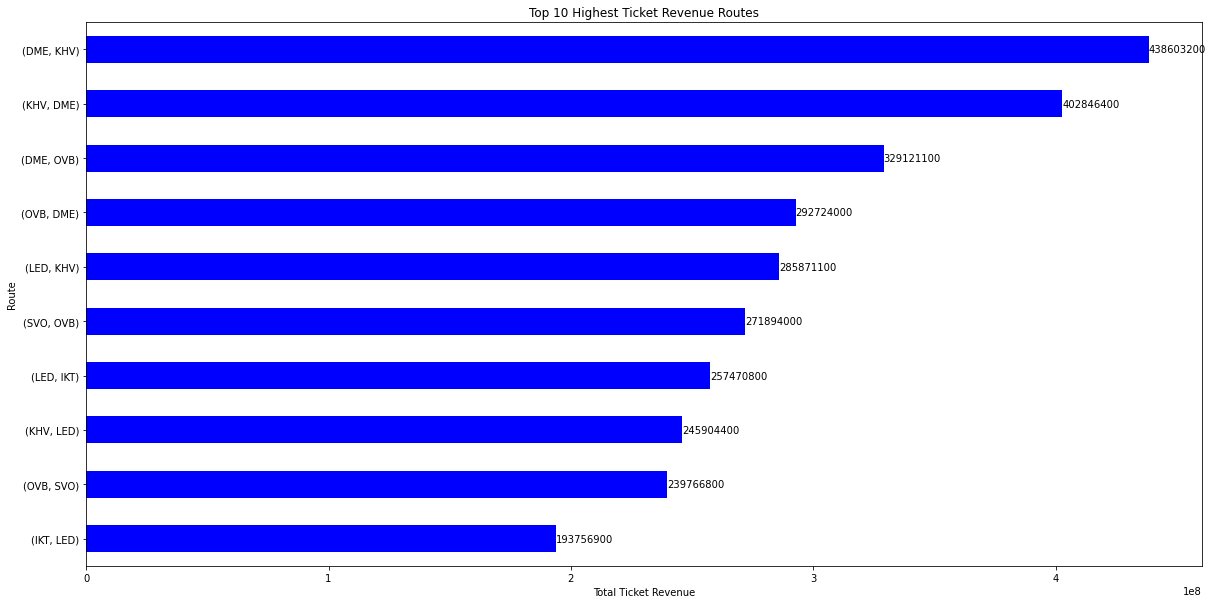

In [27]:
# Group by departure and arrival airport codes (the route) and sum revenue
route_revenue = flightss.groupby(['departure_airport', 'arrival_airport'])['ticket_revenue'].sum()

# Sort the routes by revenue in descending order
top_routes = route_revenue.sort_values(ascending=False).head(10)

# Visualize the top routes in a horizontal bar chart
top_routes.plot(kind='barh', color='blue', figsize=(20, 10))
plt.title('Top 10 Highest Ticket Revenue Routes')
plt.xlabel('Total Ticket Revenue')
plt.ylabel('Route')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest revenue at the top
for index, value in enumerate(top_routes):
    plt.text(value, index, str(round(value, 2)), ha='left', va='center')  # Display revenue values on the bars
plt.show()

**2. What routes in the network have the highest number of passengers ?**

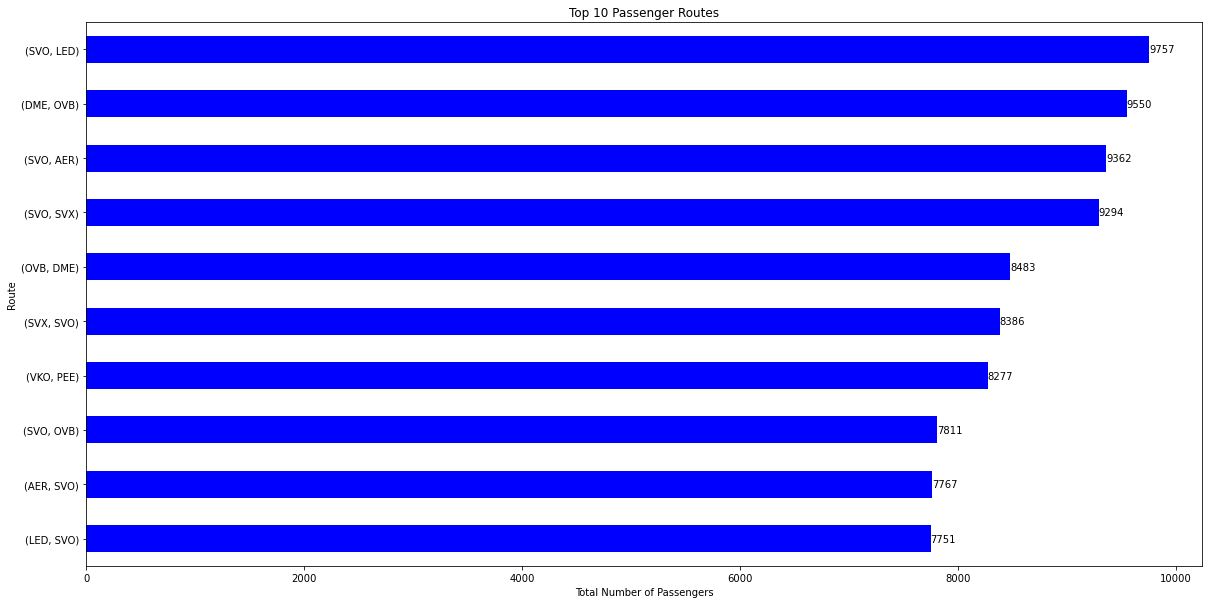

In [28]:
# Group by departure and arrival airport codes, and count passenger
route_passengers = flightss.groupby(['departure_airport', 'arrival_airport'])['passenger_count'].sum()

# Sort the routes by revenue in descending order
top_passenger_routes = route_passengers.sort_values(ascending=False).head(10)

# Visualize the top routes in a horizontal bar chart
top_passenger_routes.plot(kind='barh', color='blue', figsize=(20, 10))
plt.title('Top 10 Passenger Routes')
plt.xlabel('Total Number of Passengers')
plt.ylabel('Route')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest revenue at the top
for index, value in enumerate(top_passenger_routes):
    plt.text(value, index, str(round(value, 2)), ha='left', va='center')  # Display revenue values on the bars
plt.show()

3. **What are the top 10 flights routes in the network ?**

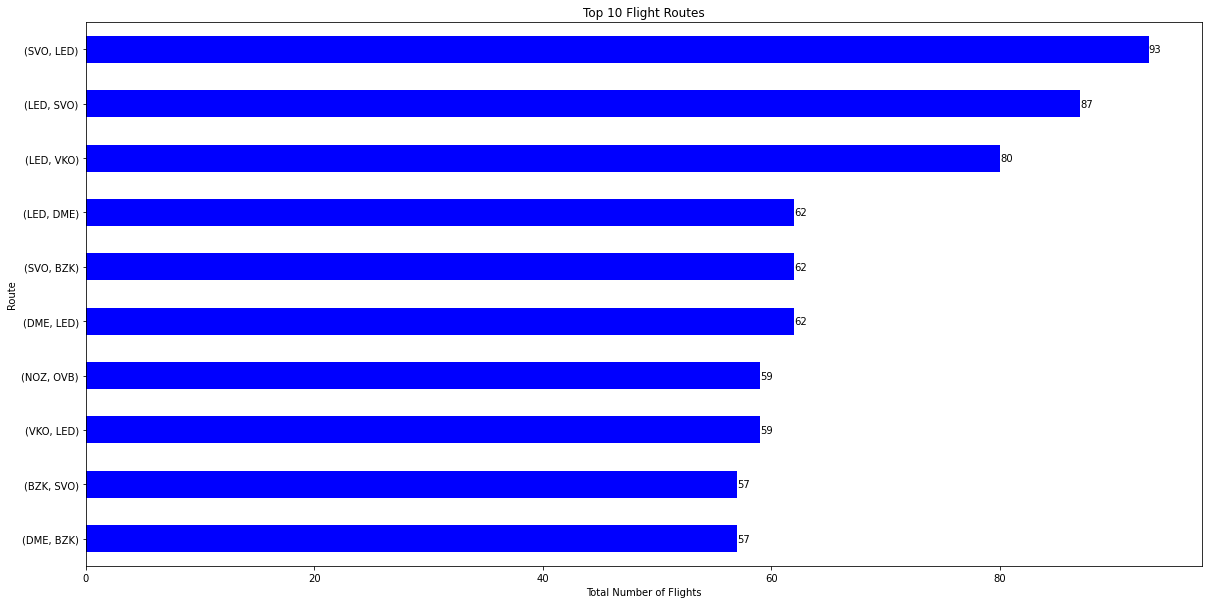

In [29]:
# Group by departure and arrival airport codes, and count flights
route_flights = flightss.groupby(['departure_airport', 'arrival_airport'])['flight_id'].count()

# Sort the routes by number of flights in descending order
top_flight_routes = route_flights.sort_values(ascending=False).head(10)

# Visualize the top routes in a horizontal bar chart
top_flight_routes.plot(kind='barh', color='blue', figsize=(20, 10))
plt.title('Top 10 Flight Routes')
plt.xlabel('Total Number of Flights')
plt.ylabel('Route')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest number of flights at the top
for index, value in enumerate(top_flight_routes):
    plt.text(value, index, str(value), ha='left', va='center')  # Display flight counts on the bars
plt.show()


**Looking at the results of top revenue , passengers and flights its evident that a route A-B is different from route B-A. For example top 2 revenue are DME - KHV and KHV - DME. For the purpose of this analysis I aim to consider A-B the same as B-A for in the next part of the analysis I will be agregating the flights dataset to capture for each route its revenue , no_flights , avg_revenue and number of passengers. There after i will combine A-B to mean the same as B-A**

In [30]:
# Group by departure and arrival airport codes, and aggregate flight count, total revenue, and passenger count
route_summary = flightss.groupby(['departure_airport', 'arrival_airport']).agg(
    flight_count=('flight_id', 'count'),
    total_revenue=('ticket_revenue', 'sum'),
    passenger_count=('passenger_count', 'sum')
)

# Reset index after grouping
route_summary.reset_index(inplace=True)

# Rename the columns for clarity
route_summary.rename(columns={
    'departure_airport': 'Departure_Airport',
    'arrival_airport': 'Arrival_Airport',
    'flight_count': 'Flight_Count',
    'total_revenue': 'Total_Revenue',
    'passenger_count': 'Passenger_Count'
}, inplace=True)

# Sort the routes by number of flights in descending order
route_summary = route_summary.sort_values(by='Flight_Count', ascending=False)

# Reset index after sorting
route_summary.reset_index(drop=True, inplace=True)

# Trim leading and trailing whitespace from string columns
route_summary['Departure_Airport'] = route_summary['Departure_Airport'].str.strip()
route_summary['Arrival_Airport'] = route_summary['Arrival_Airport'].str.strip()

# Display the resulting DataFrame
display(route_summary)

,Departure_Airport,Arrival_Airport,Flight_Count,Total_Revenue,Passenger_Count
0,SVO,LED,93,78312000,9757
1,LED,SVO,87,61897200,7751
2,LED,VKO,80,48805500,5815
3,LED,DME,62,46209600,5170
4,SVO,BZK,62,15971300,3417
...,...,...,...,...,...
446,GDX,MRV,3,6522100,69
447,CEE,NOZ,3,1084900,32
448,TOF,VOG,3,4302400,121
449,DYR,KHV,3,5396200,135


In [31]:
# Sanity check for duplicates
duplicates_check = route_summary[(route_summary['Departure_Airport'] == 'LED') & (route_summary['Arrival_Airport'] == 'VKO')]
duplicates_check

,Departure_Airport,Arrival_Airport,Flight_Count,Total_Revenue,Passenger_Count
2,LED,VKO,80,48805500,5815


In [32]:
df = route_summary.copy()
# df = df[['Departure_Airport' , 'Arrival_Airport','Flight_Count','Total_Revenue','Passenger_Count']]

G = df.rename(columns={'Departure_Airport': 'A', 'Arrival_Airport': 'B'})
GT = df.rename(columns={'Departure_Airport': 'B', 'Arrival_Airport': 'A'})
display(G.head(3))
display(GT.head(3))


H = pd.merge(G, GT, on=['A', 'B'], suffixes=('_G', '_GT'))

# Create a new column with sorted combination of 'A' and 'B'
H['Sorted_AB'] = H.apply(lambda row: '-'.join(sorted([row['A'], row['B']])), axis=1)

# Drop duplicates based on the sorted combination of 'A' and 'B'
H.drop_duplicates(subset=['Sorted_AB'], inplace=True)

# Drop the 'Sorted_AB' column as it's no longer needed
H.drop(columns=['Sorted_AB'], inplace=True)

display(H)

H['Total_Revenue'] = H['Total_Revenue_G'] + H['Total_Revenue_GT']
H['Passenger_Count'] = H['Passenger_Count_G'] + H['Passenger_Count_GT']
H['Flight_Count'] = H['Flight_Count_G'] + H['Flight_Count_GT']

display(H)

markov_data = H[['A' , 'B','Total_Revenue', 'Passenger_Count','Flight_Count']]

display(markov_data)


,A,B,Flight_Count,Total_Revenue,Passenger_Count
0,SVO,LED,93,78312000,9757
1,LED,SVO,87,61897200,7751
2,LED,VKO,80,48805500,5815


,B,A,Flight_Count,Total_Revenue,Passenger_Count
0,SVO,LED,93,78312000,9757
1,LED,SVO,87,61897200,7751
2,LED,VKO,80,48805500,5815


,A,B,Flight_Count_G,Total_Revenue_G,Passenger_Count_G,Flight_Count_GT,Total_Revenue_GT,Passenger_Count_GT
0,SVO,LED,93,78312000,9757,87,61897200,7751
2,LED,VKO,80,48805500,5815,59,48747500,5828
3,LED,DME,62,46209600,5170,62,46098000,5188
4,SVO,BZK,62,15971300,3417,57,11661300,2517
6,NOZ,OVB,59,8718400,2301,31,9629100,2556
...,...,...,...,...,...,...,...,...
427,AER,KGP,4,2358500,63,3,1654800,42
433,SVO,RGK,4,2104300,51,3,1283600,35
435,MRV,GDX,4,10628600,124,3,6522100,69
436,NOZ,CEE,4,1563200,46,3,1084900,32


,A,B,Flight_Count_G,Total_Revenue_G,Passenger_Count_G,Flight_Count_GT,Total_Revenue_GT,Passenger_Count_GT,Total_Revenue,Passenger_Count,Flight_Count
0,SVO,LED,93,78312000,9757,87,61897200,7751,140209200,17508,180
2,LED,VKO,80,48805500,5815,59,48747500,5828,97553000,11643,139
3,LED,DME,62,46209600,5170,62,46098000,5188,92307600,10358,124
4,SVO,BZK,62,15971300,3417,57,11661300,2517,27632600,5934,119
6,NOZ,OVB,59,8718400,2301,31,9629100,2556,18347500,4857,90
...,...,...,...,...,...,...,...,...,...,...,...
427,AER,KGP,4,2358500,63,3,1654800,42,4013300,105,7
433,SVO,RGK,4,2104300,51,3,1283600,35,3387900,86,7
435,MRV,GDX,4,10628600,124,3,6522100,69,17150700,193,7
436,NOZ,CEE,4,1563200,46,3,1084900,32,2648100,78,7


,A,B,Total_Revenue,Passenger_Count,Flight_Count
0,SVO,LED,140209200,17508,180
2,LED,VKO,97553000,11643,139
3,LED,DME,92307600,10358,124
4,SVO,BZK,27632600,5934,119
6,NOZ,OVB,18347500,4857,90
...,...,...,...,...,...
427,AER,KGP,4013300,105,7
433,SVO,RGK,3387900,86,7
435,MRV,GDX,17150700,193,7
436,NOZ,CEE,2648100,78,7


**PageRank Analysis: Utilize PageRank algorithm to uncover insights and rank elements based on their importance within the network, addressing specific business questions.**

The markov_data prepared in the previous section is a way we used to properly define our nodes (Airport A and B) and edges (Route A- B). To use page-rank these edges should have weights based on our metrics : Revenue , Passenger Count and Flight Count.

The Markov Chain, a fundamental concept in probability theory, is characterized by transitions between states, where the probability of transitioning to a future state depends solely on the current state. In our context, the aim is to determine the transition probabilities between airports based on the weighted routes.

The weighted transition matrix (P) represents the probabilities of transitioning from one state (or node, in the context of PageRank) to another. In the context of PageRank, P captures the probabilities of moving from one web page (Airport) to another through hyperlinks.The main goal of the PageRank algorithm is  to find the stationary probability distribution x(t), where x(t) represents the probability vector of being at each node (or airport or web page) at time t , higher values of x_i(t) indicates greater importance. This stationary distribution represents the long-term probability of a random surfer (or passenger) being at each web page (airport) in the network. It identifies the relative importance or ranking of each node in the network.

**Using the prepared data, I will procede with the steps below to complete the pagerank algorithm on our data:** 

1. Weight Definition: Define weights based on the chosen metrics (e.g., revenue, passenger count, flight count) to represent the importance of each route.

2. Weighted Transition Matrix (P): Construct a weighted transition matrix (P) where each entry represents the probability of transitioning from one airport to another based on the defined weights.

3. Sparse Matrix Conversion: Convert the Markov data into a sparse matrix format to efficiently handle large datasets.

4. Calculation of x(t): Utilize a custom function that we developed in Notebook 11 (CSE 6040) to calculate the stationary probability vector x(t). This vector represents the long-term probabilities of being at each airport.

In [33]:
#In this code cell I will be defining the weights to be used in the transition Matrix P
#I will be normalizing revenue , passengers  and flights metrics and assigning each a weight.
#For this analysis i assigned revenue a higher score compared to passenger and flight numbers but its all for exploration purposes and the weight can be defined based on a business understanding. 


pagerank_data = markov_data.copy()

# Normalize the data
pagerank_data['Normalized_Revenue'] = (pagerank_data['Total_Revenue'] - pagerank_data['Total_Revenue'].min()) / (pagerank_data['Total_Revenue'].max() - pagerank_data['Total_Revenue'].min())
pagerank_data['Normalized_Passenger'] = (pagerank_data['Passenger_Count'] - pagerank_data['Passenger_Count'].min()) / (pagerank_data['Passenger_Count'].max() - pagerank_data['Passenger_Count'].min())
pagerank_data['Normalized_Flights'] = (pagerank_data['Flight_Count'] - pagerank_data['Flight_Count'].min()) / (pagerank_data['Flight_Count'].max() - pagerank_data['Flight_Count'].min())

# Assign weights
weight_revenue = 0.4
weight_passengers = 0.3
weight_flights = 0.3

# Calculate the weighted metric
pagerank_data['Weighted_Metric'] = (weight_revenue * pagerank_data['Normalized_Revenue']) + (weight_passengers * pagerank_data['Normalized_Passenger']) + (weight_flights * pagerank_data['Normalized_Flights'])

# Display the resulting DataFrame
display(pagerank_data)


,A,B,Total_Revenue,Passenger_Count,Flight_Count,Normalized_Revenue,Normalized_Passenger,Normalized_Flights,Weighted_Metric
0,SVO,LED,140209200,17508,180,0.166451,0.970861,1.000000,0.657839
2,LED,VKO,97553000,11643,139,0.115746,0.645335,0.764368,0.469209
3,LED,DME,92307600,10358,124,0.109511,0.574013,0.678161,0.419457
4,SVO,BZK,27632600,5934,119,0.032633,0.328468,0.649425,0.306421
6,NOZ,OVB,18347500,4857,90,0.021596,0.268691,0.482759,0.234073
...,...,...,...,...,...,...,...,...,...
427,AER,KGP,4013300,105,7,0.004558,0.004940,0.005747,0.005029
433,SVO,RGK,3387900,86,7,0.003814,0.003885,0.005747,0.004415
435,MRV,GDX,17150700,193,7,0.020174,0.009824,0.005747,0.012741
436,NOZ,CEE,2648100,78,7,0.002935,0.003441,0.005747,0.003930


In [34]:
#Count the number of distinct airports to be used in creating the sparse matrix 

# Count the number of distinct airport codes in column 'A'
distinct_a = pagerank_data['A'].nunique()

# Count the number of distinct airport codes in column 'B'
distinct_b = pagerank_data['B'].nunique()

# Add the counts together
total_distinct_airports = distinct_a + distinct_b
total_distinct_airports

150

In [35]:
#For the purpose of creating a sparse matrix we'd have to work with numerical variables for the airport codes and not the airport codes themselves to allow for numerical computation.
# In this block i will assigning each airport code a unique index value.


# Create a set of unique airport codes
all_airports = set(pagerank_data['A'].unique()).union(pagerank_data['B'].unique())

# Create a mapping of airport codes to integer indices
airport_to_index = {airport: index for index, airport in enumerate(sorted(all_airports))}

# Create a reverse mapping of integer indices to airport codes
index_to_airport = {index: airport for airport, index in airport_to_index.items()}

# Replace airport codes with integer indices in 'A' and 'B' columns
pagerank_data['A_index'] = pagerank_data['A'].map(airport_to_index)
pagerank_data['B_index'] = pagerank_data['B'].map(airport_to_index)

# Display the modified DataFrame
display(pagerank_data.head())

,A,B,Total_Revenue,Passenger_Count,Flight_Count,Normalized_Revenue,Normalized_Passenger,Normalized_Flights,Weighted_Metric,A_index,B_index
0,SVO,LED,140209200,17508,180,0.166451,0.970861,1.000000,0.657839,71,37
2,LED,VKO,97553000,11643,139,0.115746,0.645335,0.764368,0.469209,37,88
3,LED,DME,92307600,10358,124,0.109511,0.574013,0.678161,0.419457,37,13
4,SVO,BZK,27632600,5934,119,0.032633,0.328468,0.649425,0.306421,71,8
6,NOZ,OVB,18347500,4857,90,0.021596,0.268691,0.482759,0.234073,49,56


In [36]:
#create a visualization for a sparse matrix 
import matplotlib.pyplot as plt
%matplotlib inline

def spy(A , figsize=(6,6), markersize = 0.5):
    #visualise sparse matrix
    fig = plt.figure(figsize = figsize)
    plt.spy(A, markersize = markersize)
    plt.show()


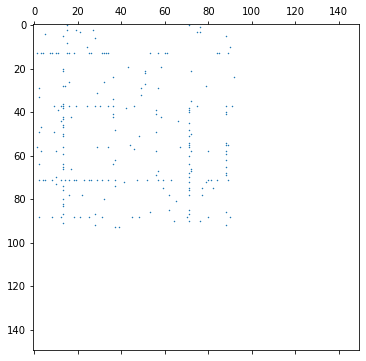

In [37]:
#Using the output in the cells leading up to this , create a sparse matrix.

#sparse matrix
P = sp.sparse.coo_matrix((pagerank_data['Weighted_Metric'],(pagerank_data['A_index'], pagerank_data['B_index'])),shape=(total_distinct_airports, total_distinct_airports)) 

# Visually inspect your result:
spy(P)

In [38]:
# In this steap i initialize the initial probability vector x(o) to represent the starting state probabilities for each airport in the Markov Chain process.
# It ndicate the probability of being at each airport at the start of the Markov Chain process.

# Initialize x0 as an array of zeros with length n_airports
x0 = np.zeros(total_distinct_airports)

# Get the unique indices of actual airports
actual_airport_indices = pagerank_data['A_index'].unique()

# Set the elements corresponding to actual airport indices to 1.0 / n_actual
x0[actual_airport_indices] = 1.0 / total_distinct_airports

# Define a function to display the non-zero elements of a vector sparsely
def display_vec_sparsely(x, name='x'):
    i_nz = np.argwhere(x).flatten()
    df_x_nz = pd.DataFrame({'i': i_nz, '{}[i] (non-zero only)'.format(name): x[i_nz]})
    display(df_x_nz.head())
    print("...")
    display(df_x_nz.tail())

# Display the non-zero elements of x0
display_vec_sparsely(x0, name='x0')


,i,x0[i] (non-zero only)
0,0,0.006667
1,1,0.006667
2,2,0.006667
3,3,0.006667
4,4,0.006667


...


,i,x0[i] (non-zero only)
69,88,0.006667
70,90,0.006667
71,91,0.006667
72,92,0.006667
73,93,0.006667


In [39]:
# In this function, I compute the state probabilities x(t) at time t by iteratively multiplying the transpose of the transition matrix P with the initial probability vector x0. 
# This step quantifies the probabilities of transitioning between airports over time, capturing the dynamics of the airport network. 
# I also sort these probabilities to obtain the ranks of the airports

def eval_markov_chain(P, x0, t_max):
    x = x0
    for t in range(t_max):
        x = P.T.dot(x)
    return x 

T_MAX = 50
x0_copy = x0.copy()
x = eval_markov_chain(P, x0, T_MAX)
display_vec_sparsely(x)
assert all(x0 == x0_copy), "Did your implementation modify `x0`? It shouldn't do that!"

print("\n=== Top 10 airports ===\n")
# Assuming `airport_data` contains information about airports
# Adjust the indexing method according to your dataset structure
ranks = np.argsort(-x)

top10_airport_indices = ranks[:10]
top10_airport_codes = [index_to_airport[index] for index in top10_airport_indices]

# Create the DataFrame with airport codes
top10_df = pd.DataFrame({'Rank': np.arange(1, 11),
                         'Code': top10_airport_codes,
                         'x(t)': x[top10_airport_indices]})

top10_df[['Code','Rank','x(t)']]


,i,x[i] (non-zero only)
0,1,2.435614e-14
1,2,1.564550e-13
2,3,6.081838e-14
3,4,6.227552e-14
4,5,9.312871e-15


...


,i,x[i] (non-zero only)
65,88,8.523987e-14
66,89,6.186597e-14
67,90,5.439865e-14
68,91,1.434858e-14
69,92,1.156494e-14



=== Top 10 airports ===



,Code,Rank,x(t)
0,DME,1,2.266590e-13
1,AER,2,1.564550e-13
2,BZK,3,1.500427e-13
3,KRR,4,1.433101e-13
4,EGO,5,1.255709e-13
5,OVS,6,1.112351e-13
6,KGD,7,1.007402e-13
7,KUF,8,1.006137e-13
8,KVX,9,9.203634e-14
9,ESL,10,8.916581e-14


In [40]:
# In the code below I am simply mapping the codes obtained to actual airport names and cities

# Extract unique combinations of departure airport code, city, and name
unique_airports = flightss[['departure_airport', 'departure_city_name', 'departure_airport_name']].drop_duplicates()

# Create a dictionary mapping airport codes to airport names and city names
airport_map = unique_airports.set_index('departure_airport')[['departure_city_name', 'departure_airport_name']].to_dict(orient='index')

# Map airport codes in top10_df to airport names and city names
top10_df['Departure_Airport_Name'] = top10_df['Code'].map(lambda x: airport_map.get(x, {}).get('departure_airport_name'))
top10_df['Departure_City_Name'] = top10_df['Code'].map(lambda x: airport_map.get(x, {}).get('departure_city_name'))

# Reorder columns
top10_df = top10_df[['Rank', 'Code', 'Departure_Airport_Name', 'Departure_City_Name', 'x(t)']]


# Display the resulting DataFrame
display(top10_df)


,Rank,Code,Departure_Airport_Name,Departure_City_Name,x(t)
0,1,DME,Domodedovo International Airport,Moscow,2.266590e-13
1,2,AER,Sochi International Airport,Sochi,1.564550e-13
2,3,BZK,Bryansk Airport,Bryansk,1.500427e-13
3,4,KRR,Krasnodar Pashkovsky International Airport,Krasnodar,1.433101e-13
4,5,EGO,Belgorod International Airport,Belgorod,1.255709e-13
5,6,OVS,Sovetskiy Airport,Sovetskiy,1.112351e-13
6,7,KGD,Khrabrovo Airport,Kaliningrad,1.007402e-13
7,8,KUF,Kurumoch International Airport,Samara,1.006137e-13
8,9,KVX,Pobedilovo Airport,Kirov,9.203634e-14
9,10,ESL,Elista Airport,Elista,8.916581e-14


**Comparison of Rankings: Conduct a comparative analysis between historical rankings and those derived from PageRank (a form of Markov Chain), highlighting differences and identifying which method provides more valuable insights for the business.**

- Based on the results Domodedovo International Airport is the most important airport in the Network and based on our historical data it was an airport in the top route based on revenue , 2nd in passenger routes and 4th for top flight routes. Markov Chains were able to take a weighted metric and establish it as the highest rank in the network.

- Sochi International Airport is of second importance which is an interesting pattern captured given that its in top three routes for passenger demand but not captured in the top 10 for revenue and flight routes.


- Overall the Analysis Highlights DME Airport as a key. airport in the network which is evident in the historical data presented earlier however the Markov Chain/Page Rank has revealed hidden patterns and relationships in data that were not immediately obvious from the individual metrics alone. Evident in the fact that some airports in the Markov Rank were not ranked high in the historical data.By considering the transitions between airports and their associated weights, Markov chains capture the complex interactions within the airport network, potentially highlighting airports that play important roles in connecting various destinations, even if they don't have the highest individual metrics. This holistic view provided by this analysis can offer valuable insights into the overall structure and dynamics of an airport network.

**Other Insights to Support Decision Making** 

**Top outbound passengers by city!**

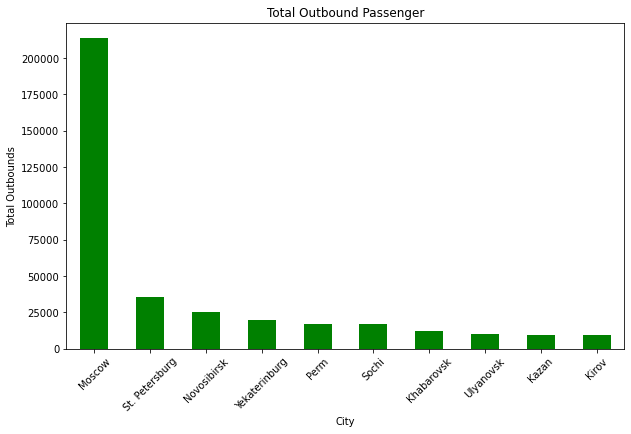

In [42]:
# Group by city 
outbound_passengers = flightss.groupby('departure_city_name')['passenger_count'].sum()

# Sort the cities by ticket revenue in descending order
top_outbounds = outbound_passengers.sort_values(ascending=False).head(10)

# Visualize total ticket revenue per city
plt.figure(figsize=(10, 6))
top_outbounds.plot(kind='bar', color='green')
plt.title('Total Outbound Passenger')
plt.xlabel('City')
plt.ylabel('Total Outbounds')
plt.xticks(rotation=45)
plt.show()

**Top inbound passengers by city!**

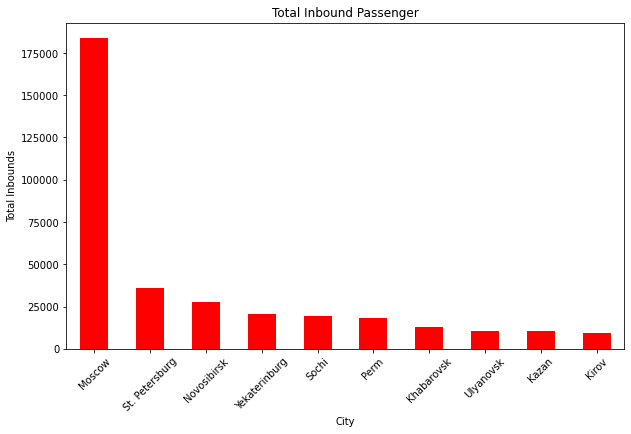

In [43]:
# Group by city 
inbound_passengers = flightss.groupby('arrival_city_name')['passenger_count'].sum()

# Sort the cities by ticket revenue in descending order
top_inbounds = inbound_passengers.sort_values(ascending=False).head(10)

# Visualize total ticket revenue per city
plt.figure(figsize=(10, 6))
top_inbounds.plot(kind='bar', color='red')
plt.title('Total Inbound Passenger')
plt.xlabel('City')
plt.ylabel('Total Inbounds')
plt.xticks(rotation=45)
plt.show()

**Time series of the total ticket revenue by depature date and by hour of the day !**

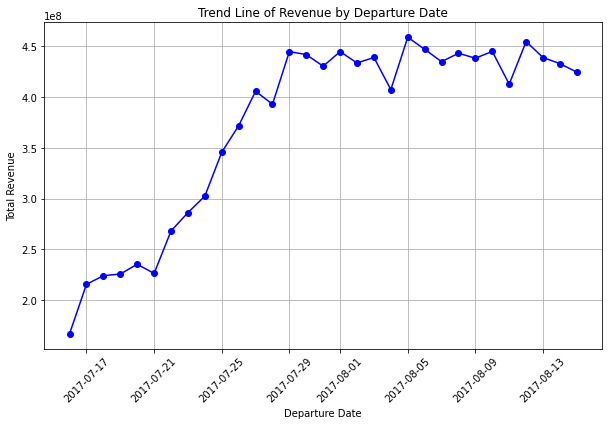

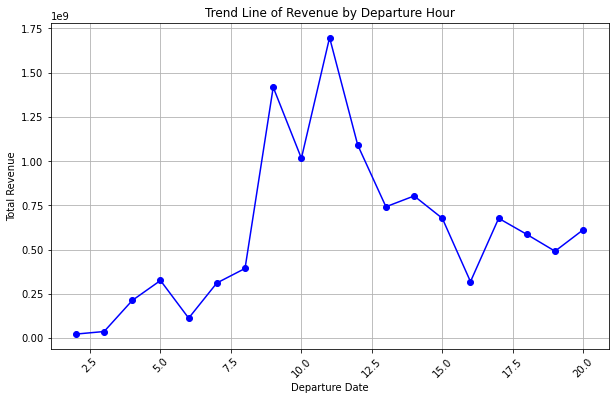

In [44]:
#Use function defined earlier in the notebook to convert to datetime for timseries
convert_to_datetime(flightss, cols)

# Extract date and hour separately
flightss['departure_date'] = flightss['scheduled_departure'].dt.date
flightss['departure_hour'] = flightss['scheduled_departure'].dt.hour

# Group by date and sum revenue and passengers
revenue_by_date = flightss.groupby('departure_date')['ticket_revenue'].sum()
revenue_by_hour = flightss.groupby('departure_hour')['ticket_revenue'].sum()


# Plot trend line for revenue by date
plt.figure(figsize=(10, 6))
plt.plot(revenue_by_date.index, revenue_by_date.values, marker='o', color='blue')
plt.title('Trend Line of Revenue by Departure Date')
plt.xlabel('Departure Date')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot trend line for revenue by hour
plt.figure(figsize=(10, 6))
plt.plot(revenue_by_hour.index, revenue_by_hour.values, marker='o', color='blue')
plt.title('Trend Line of Revenue by Departure Hour')
plt.xlabel('Departure Date')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**Time series of the total number of passengers by depature date and by hour of the day !**

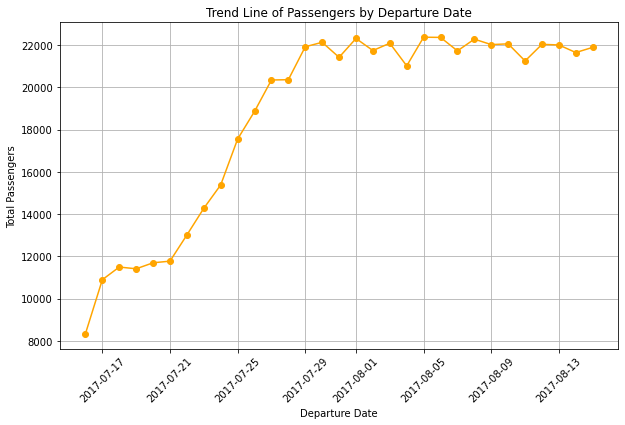

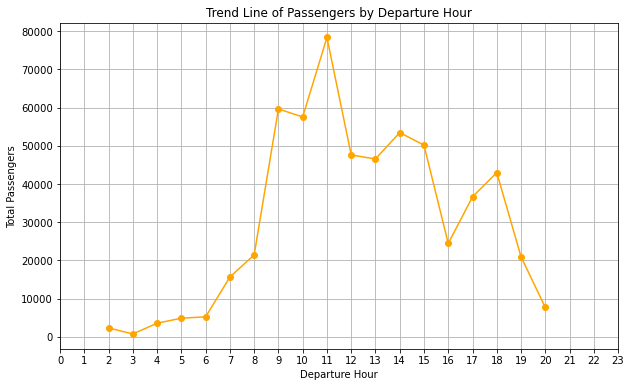

In [45]:
#group by date and hour
passengers_by_date = flightss.groupby('departure_date')['passenger_count'].sum()
passengers_by_hour = flightss.groupby('departure_hour')['passenger_count'].sum()

# Plot trend line for passengers by date
plt.figure(figsize=(10, 6))
plt.plot(passengers_by_date.index, passengers_by_date.values, marker='o', color='orange')
plt.title('Trend Line of Passengers by Departure Date')
plt.xlabel('Departure Date')
plt.ylabel('Total Passengers')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot trend line for passengers by hour
plt.figure(figsize=(10, 6))
plt.plot(passengers_by_hour.index, passengers_by_hour.values, marker='o', color='orange')
plt.title('Trend Line of Passengers by Departure Hour')
plt.xlabel('Departure Hour')
plt.ylabel('Total Passengers')
plt.xticks(range(24))
plt.grid(True)
plt.show()